In [1]:
import sys
sys.path.append('../libs/')


In [2]:
import requests
from tinkoff.invest import Client, CandleInterval, PortfolioResponse, RequestError, HistoricCandle
from tinkoff.invest.constants import INVEST_GRPC_API_SANDBOX, INVEST_GRPC_API
from datetime import datetime, timedelta, date
import pandas as pd
import matplotlib.pyplot as plt
from ta import trend

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn import metrics

import pmdarima as pm
from prophet import Prophet

# Библиотека с данными для авторизации в Тинькофф api
import cred

/home/vadim/pythonpr/invest/invest/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
def cast_money(v):
    """Функция переводит из данных в виде MoneyValue в float

    Args:
        v (MoneyValue): Данные из апи
    """
    return v.units + v.nano / 1e9

In [4]:
def create_df_candles(candles : [HistoricCandle]):
    """Функция создает data frame на основе данных по свечам из тинькофф api

    Args:
        candles (HistoricCandle]): _description_

    Returns:
        _type_: _description_
    """
    df = pd.DataFrame([{
        'time'      : c.time,
        'volume'    : c.volume,
        'open'      : cast_money(c.open),
        'close'     : cast_money(c.close),
        'high'      : cast_money(c.high),
        'low'       : cast_money(c.low)
    } for c in candles])
    
    return df

Загружаем данные по бумаге Полиметал. Данные в апи начинаются с 2013 года.
Загрузка идет по годам из за ограничений апи по количеству возвращаемых данных

In [5]:
df = pd.DataFrame()
try:
    with Client(cred.cred['readonly_token'], target=INVEST_GRPC_API) as client:
        for year in range(2013, 2023):
            r = client.market_data.get_candles(
                figi=cred.share_figies['poly'],
                from_=datetime(year, 1, 1),
                to=datetime(year, 12, 31),
                interval=CandleInterval.CANDLE_INTERVAL_DAY
            )
            df_cur = create_df_candles(r.candles)
            if df.empty:
                df = df_cur
            else:
                df = pd.concat([df, df_cur], ignore_index=True)
            #df['ema'] = trend.ema_indicator(close=df['close'], window=9)
        
except RequestError as e:
    print(str(e))

In [6]:
df

,time,volume,open,close,high,low
0,2013-06-20 07:00:00+00:00,4180,292.60,278.23,300.00,244.55
1,2013-06-21 07:00:00+00:00,4930,277.60,262.47,279.90,260.50
2,2013-06-24 07:00:00+00:00,6658,265.86,254.50,265.86,254.00
3,2013-06-25 07:00:00+00:00,5569,251.19,252.17,255.94,244.95
4,2013-06-26 07:00:00+00:00,11800,247.32,236.79,248.51,236.43
...,...,...,...,...,...,...
2463,2022-12-21 07:00:00+00:00,2463742,378.70,379.20,387.40,373.70
2464,2022-12-22 07:00:00+00:00,1404674,381.00,372.70,384.30,370.00
2465,2022-12-23 07:00:00+00:00,691435,374.00,374.30,377.70,371.60
2466,2022-12-24 07:00:00+00:00,14294,375.60,374.40,375.60,370.30


In [7]:
df['time'] = pd.to_datetime(df['time']).dt.date

In [8]:
df

,time,volume,open,close,high,low
0,2013-06-20,4180,292.60,278.23,300.00,244.55
1,2013-06-21,4930,277.60,262.47,279.90,260.50
2,2013-06-24,6658,265.86,254.50,265.86,254.00
3,2013-06-25,5569,251.19,252.17,255.94,244.95
4,2013-06-26,11800,247.32,236.79,248.51,236.43
...,...,...,...,...,...,...
2463,2022-12-21,2463742,378.70,379.20,387.40,373.70
2464,2022-12-22,1404674,381.00,372.70,384.30,370.00
2465,2022-12-23,691435,374.00,374.30,377.70,371.60
2466,2022-12-24,14294,375.60,374.40,375.60,370.30


In [9]:
# Сохраним данные в файл - пригодятся
df.to_csv('../data/poly_data.csv')

In [10]:
# Добавим в данные скользящую среднюю с окном 100, для этого используем библиотеку ta
df['ema'] = trend.ema_indicator(close=df['close'], window=100)

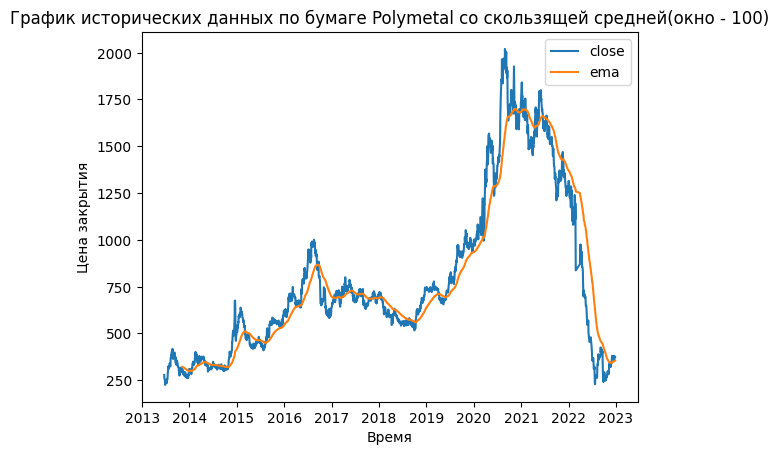

In [11]:
# Постороим график полученных исторических данных и добавим на график скользящую среднюю.
ax = df.plot(x='time', y='close')
df.plot(ax=ax, x='time', y='ema')
ax.set_title('График исторических данных по бумаге Polymetal со скользящей средней(окно - 100)')
ax.xaxis.set_label_text('Время')
ax.yaxis.set_label_text('Цена закрытия')
plt.show()

In [12]:
df_close = df[['close']]
df_close = df_close.set_index(pd.DatetimeIndex(df['time']))
df_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2468 entries, 2013-06-20 to 2022-12-25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   2468 non-null   float64
dtypes: float64(1)
memory usage: 38.6 KB


In [13]:
df_close = df_close.resample('1D').mean()
df_close = df_close.fillna(method='bfill')

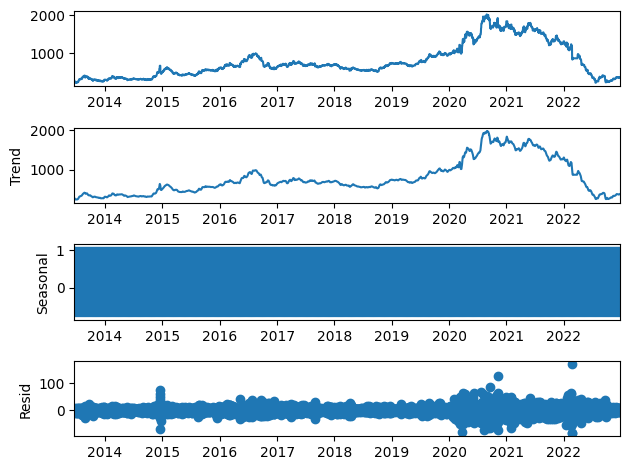

In [14]:

decomposition = seasonal_decompose(df_close)
fig = decomposition.plot()
plt.show()

В данных сезонность по выходным

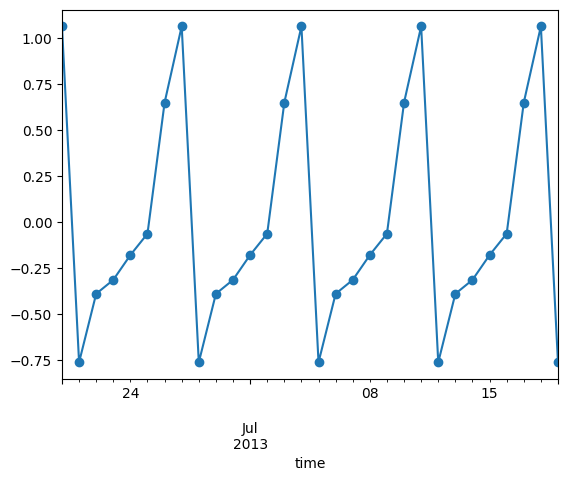

In [15]:
decomposition.seasonal[:30].plot(marker='o')
plt.show()

Проверем ряд на стационарность:

In [16]:
h0 = 'Временной ряд не стационарен'
h1 = 'Временной ряд стационарен'

result = adfuller(df_close.values)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
is_stat = True

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    if (result[0] > value):
        is_stat = False
        
print('\n')	
if is_stat:
    print(h1)
else:
    print(h0)

ADF Statistic: -1.344736
p-value: 0.608465
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Временной ряд не стационарен


Приведем ряд к стационарности

In [17]:
df_diff = df_close.diff(periods=1).dropna()
test1 = adfuller(df_diff)
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print (h0)
else:
    print (h1)

adf:  -18.32662258289956
p-value:  2.2601963944347983e-30
Critical values:  {'1%': -3.432239189510035, '5%': -2.862374736034422, '10%': -2.5672143449515703}
Временной ряд стационарен


In [18]:
#Запомним параметр d - порядок дифференцирования
d = 1

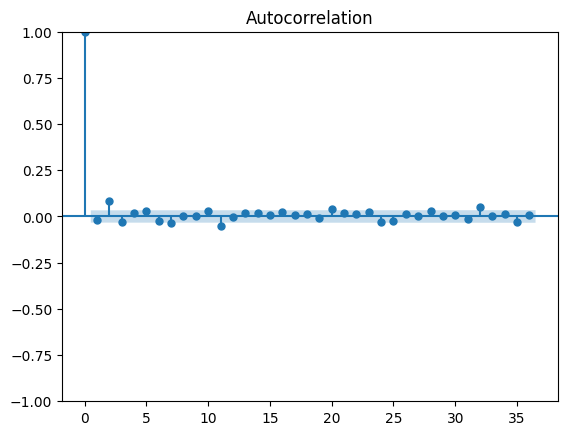

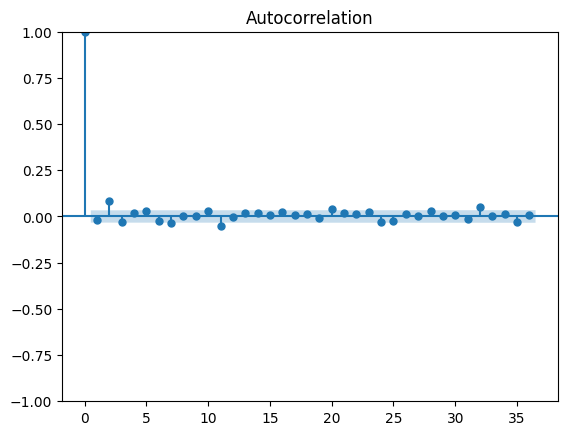

In [19]:
plot_acf(df_diff)

/home/vadim/pythonpr/invest/invest/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


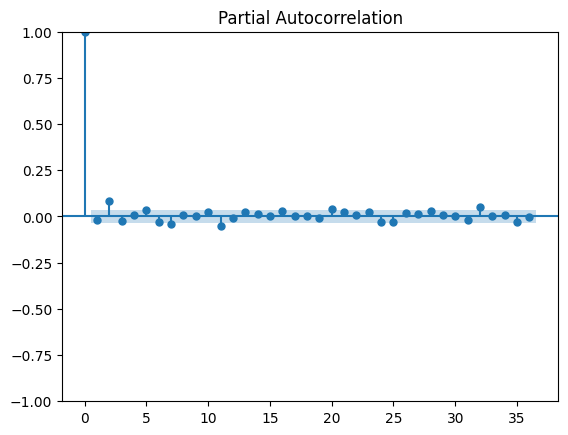

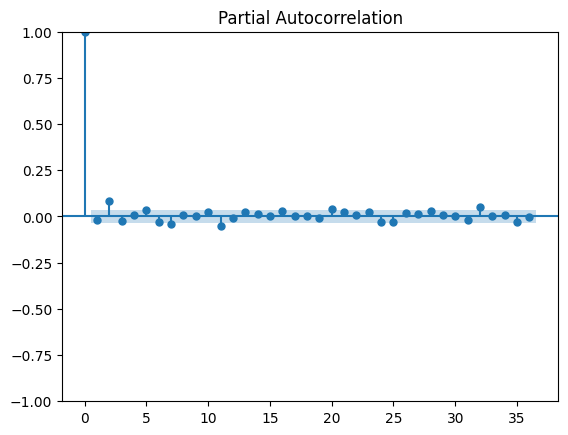

In [20]:
plot_pacf(df_diff)

Выберем p = 2

In [21]:
p = 2

Обучим ar model, для этого выделим тренировочные и тестовые данные

In [22]:
train_data = df_diff[:len(df) - 100]
test_data = df_diff[len(df) - 100:]

In [23]:
ar_model = AutoReg(train_data, lags=p).fit()

In [24]:
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                  close   No. Observations:                 2368
Model:                     AutoReg(2)   Log Likelihood               -9039.464
Method:               Conditional MLE   S.D. of innovations             11.041
Date:                Sun, 25 Dec 2022   AIC                          18086.927
Time:                        19:06:22   BIC                          18110.003
Sample:                    06-23-2013   HQIC                         18095.328
                         - 12-14-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3114      0.227      1.371      0.170      -0.134       0.757
close.L1      -0.0288      0.021     -1.400      0.162      -0.069       0.012
close.L2       0.0084      0.021      0.410      0.6

In [25]:
pred = ar_model.predict(start=len(train_data), end=len(df_diff) - 1, dynamic=False)

In [26]:
print(metrics.mean_absolute_error(test_data, pred))

14.60803481622652


In [27]:
train_data = df_close[:len(df_close) - 100]
test_data = df_close[len(df_close) - 100:]

Подберем наилучши параметры для Sarima

In [193]:
smodel = pm.auto_arima(
    train_data,
    start_p=1, max_p=5,
    start_q=1, max_q=5,
    test='adf',
    m=7,
    seasonal=True,
    d=d,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    trace=True
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=28945.032, Time=8.68 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=28954.482, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=28952.279, Time=1.06 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=28952.696, Time=3.04 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=28952.498, Time=0.10 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=28943.431, Time=5.27 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=28944.512, Time=0.92 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=28944.636, Time=11.28 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=28943.334, Time=5.93 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=28944.741, Time=10.24 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=28945.408, Time=23.60 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=28952.565, Time=4.46 sec
 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=28932.513, Time=6.98 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=28935.100, Time=1.74 sec
 ARIMA(2,1,1)(2,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 3368
Model:             SARIMAX(3, 1, 0)x(1, 0, 0, 7)   Log Likelihood              -14460.100
Date:                           Sun, 18 Dec 2022   AIC                          28930.199
Time:                                   20:20:58   BIC                          28960.808
Sample:                               06-20-2013   HQIC                         28941.145
                                    - 09-08-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0209      0.011     -1.932      0.053      -0.042       0.000
ar.L2          0.0801      0.011      7.091      0.000       0.058       0.102
ar.L3         -0.0250      0.011     -2.236      0.025      -0.047      -0.003
ar.S.L7       -0.0372      0.011     -3.498      0.000      -0.058      -0.016
sigma2       314.6374      2.456    128.115      0.000     309.824     319.451
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            189434.60
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               5.31   Skew:                            -1.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
# По результатам теста получаем параметры
p = 3
d = 1
q = 0
order = (p, d, q)
seasonal_order = (1, 0, 0, 7)

In [29]:
am = SARIMAX(train_data.close, order=order, seasonal_order=seasonal_order)
am_fit = am.fit()
am_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.29234D+00    |proj g|=  1.97410D-03


 This problem is unconstrained.



At iterate    5    f=  4.29234D+00    |proj g|=  3.10232D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     13      1     0     0   7.486D-07   4.292D+00
  F =   4.2923372943057432     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             close   No. Observations:                 3376
Model:             SARIMAX(3, 1, 0)x(1, 0, 0, 7)   Log Likelihood              -14490.931
Date:                           Sun, 25 Dec 2022   AIC                          28991.861
Time:                                   19:06:30   BIC                          29022.482
Sample:                               06-20-2013   HQIC                         29002.810
                                    - 09-16-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0208      0.011     -1.929      0.054      -0.042       0.000
ar.L2          0.0800      0.011      7.100      0.000       0.058       0.102
ar.L3         -0.0251      0.011     -2.249      0.025      -0.047      -0.003
ar.S.L7       -0.0366      0.011     -3.453      0.001      -0.057      -0.016
sigma2       313.9801      2.446    128.376      0.000     309.186     318.774
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            190770.59
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               5.30   Skew:                            -1.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
pred_df = pd.DataFrame(index=df_close.index)
preds = am_fit.predict(start=len(train_data), end=len(df_close) - 1)
pred_df['model_preds'] = preds
pred_df['close'] = df_close['close']
pred_df.tail(20)

,model_preds,close
time,,
2022-12-06,394.744829,375.1
2022-12-07,394.744829,378.0
2022-12-08,394.744829,374.0
2022-12-09,394.744829,374.3
2022-12-10,394.744829,373.1
2022-12-11,394.744829,374.4
2022-12-12,394.744829,369.0
2022-12-13,394.744829,378.6
2022-12-14,394.744829,375.4


In [31]:
print(metrics.mean_absolute_error(test_data, preds))

79.05290999305306


Ошибка великовата, получим диапозон предсказаний

In [32]:
def forecast_diaposon(am_fit, test_df, field):
    forecast = am_fit.get_forecast(len(test_df.index))
    forecast_df = forecast.conf_int(alpha = 0.5) # Confidence level of 50%

    pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower "+ field]
    pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper "+ field]

In [33]:
def print_plot(pred_df, test_df, field):
    plt.rcParams["figure.figsize"] = 18, 12

    plt.subplot(2, 1, 1)
    plt.plot(pred_df[field], color = "blue", label = "Actuals", alpha = 0.4)
    plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
    plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
    plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.4)
    plt.title("Full Model Fit", size = 24)
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(pred_df.loc[test_df.index][field], color = "blue", label = "Actuals", alpha = 0.6)
    plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
    plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
    plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
    plt.title("Out of Sample Fit", size = 24)
    plt.legend()

    plt.show()

In [34]:
forecast_diaposon(am_fit, test_data, 'close')

In [35]:
pred_df

,model_preds,close,model_preds_lower,model_preds_upper
time,,,,
2013-06-20,NaN,278.23,NaN,NaN
2013-06-21,NaN,262.47,NaN,NaN
2013-06-22,NaN,254.50,NaN,NaN
2013-06-23,NaN,254.50,NaN,NaN
2013-06-24,NaN,254.50,NaN,NaN
...,...,...,...,...
2022-12-21,394.744829,379.20,277.561232,511.928425
2022-12-22,394.744829,372.70,276.954824,512.534834
2022-12-23,394.744829,374.30,276.351522,513.138136


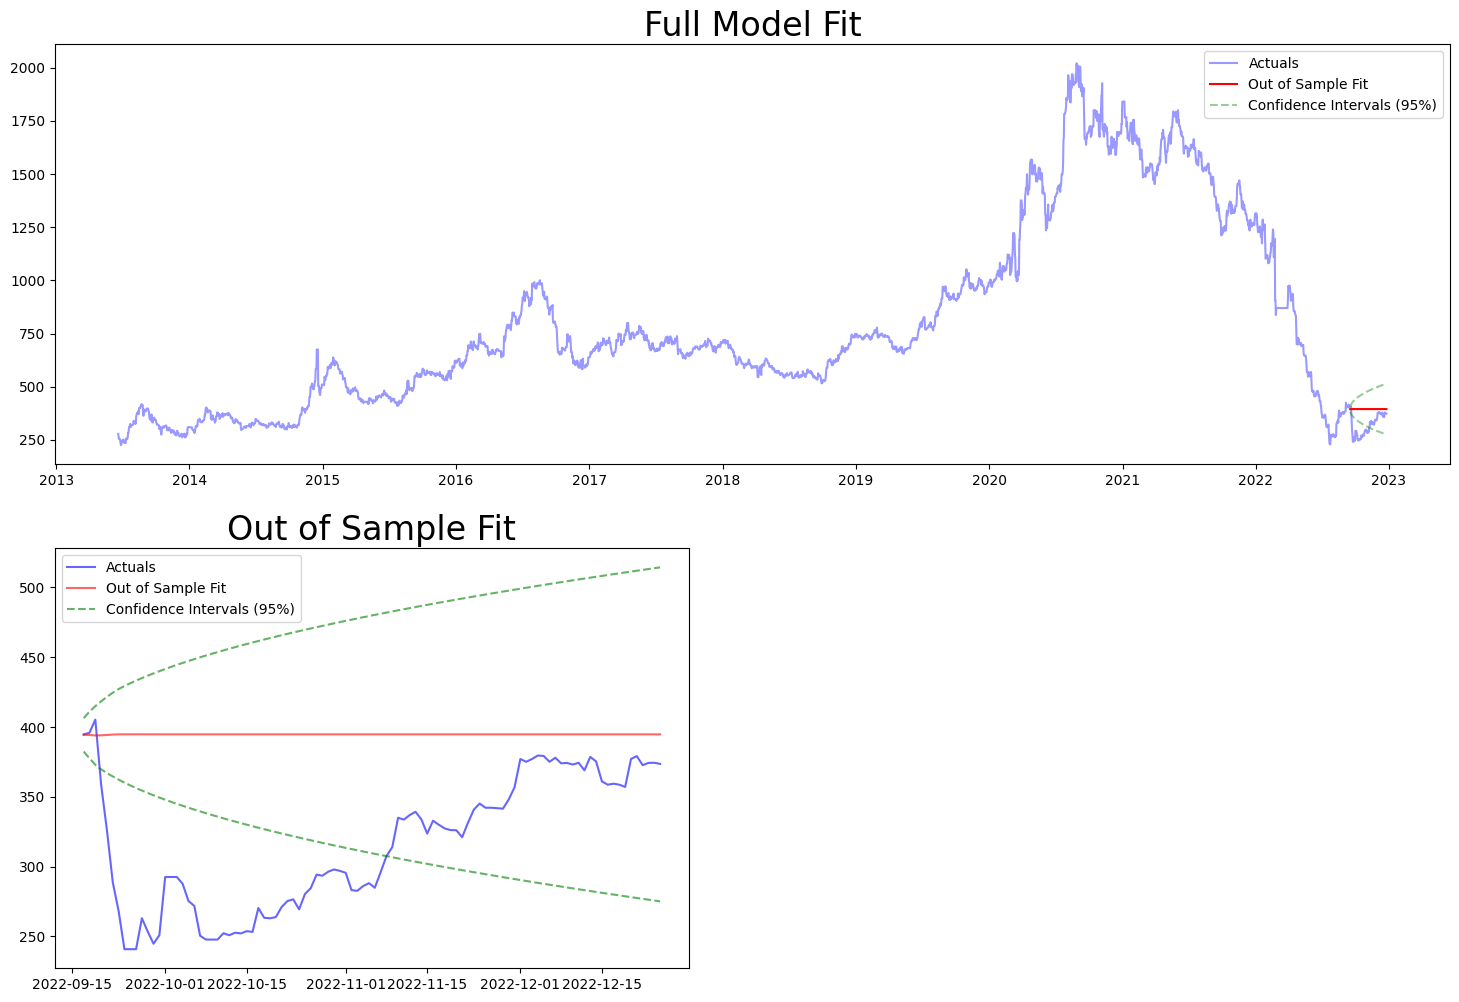

In [36]:
print_plot(pred_df, test_data, 'close')

В целом получили не очень хороший результат

Попробуем prophet

In [37]:
train_data_pr = train_data.reset_index()
train_data_pr = train_data_pr.rename({
    'time'  : 'ds',
    'close' : 'y'
}, axis=1)

In [38]:
m = Prophet(daily_seasonality=True)
m.fit(train_data_pr)

19:06:32 - cmdstanpy - INFO - Chain [1] start processing
19:06:35 - cmdstanpy - INFO - Chain [1] done processing


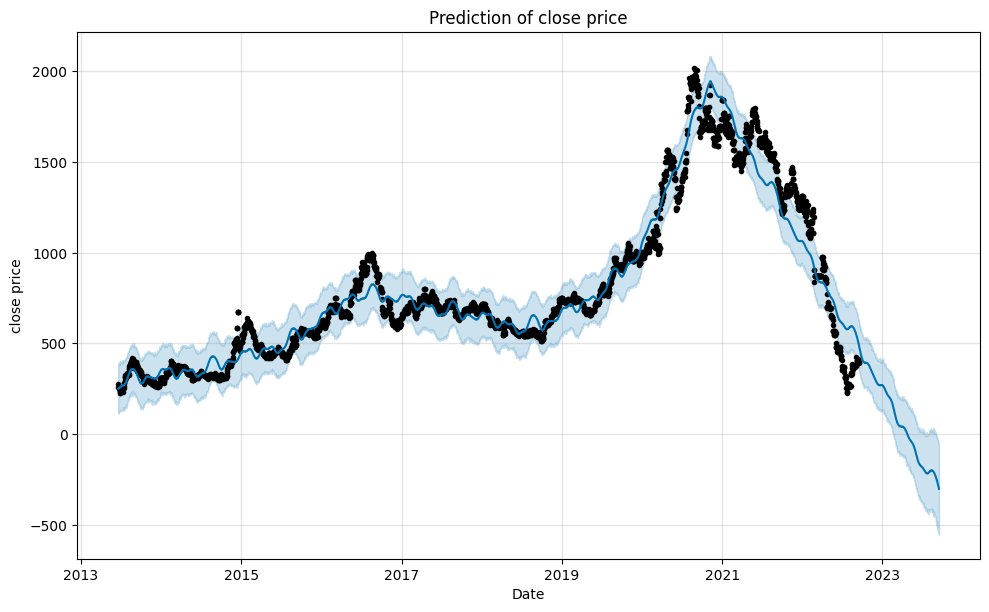

In [39]:
future = m.make_future_dataframe(periods=365)
preds = m.predict(future)
m.plot(preds)

plt.title("Prediction of close price")
plt.xlabel("Date")
plt.ylabel("close price")
plt.show()

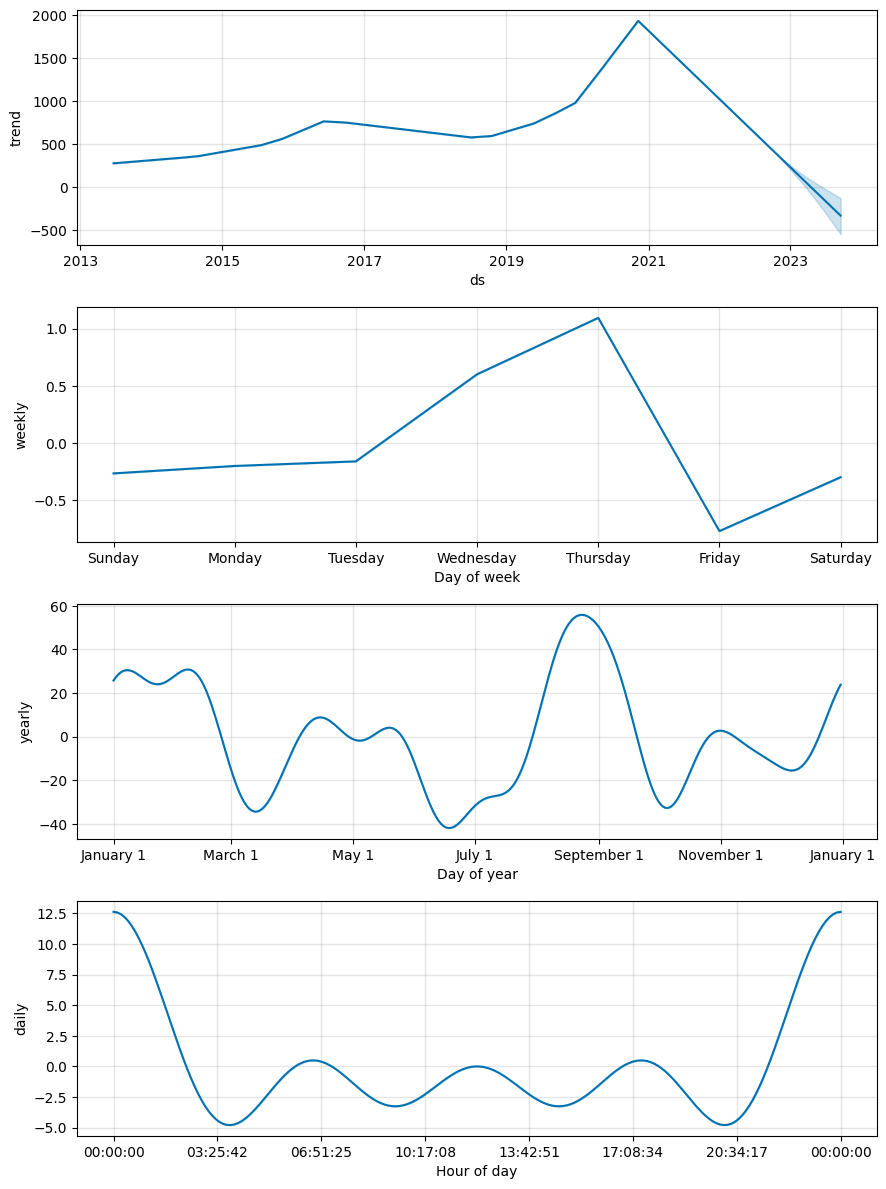

In [40]:
m.plot_components(preds)
plt.show()

In [41]:
preds

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-06-20,278.630024,136.035076,390.730218,278.630024,278.630024,-27.762091,-27.762091,-27.762091,12.62423,...,1.093807,1.093807,1.093807,-41.480128,-41.480128,-41.480128,0.0,0.0,0.0,250.867933
1,2013-06-21,278.813196,115.852636,383.414181,278.813196,278.813196,-29.132070,-29.132070,-29.132070,12.62423,...,-0.769538,-0.769538,-0.769538,-40.986762,-40.986762,-40.986762,0.0,0.0,0.0,249.681126
2,2013-06-22,278.996368,124.371903,386.747344,278.996368,278.996368,-28.006723,-28.006723,-28.006723,12.62423,...,-0.298840,-0.298840,-0.298840,-40.332112,-40.332112,-40.332112,0.0,0.0,0.0,250.989646
3,2013-06-23,279.179540,112.789738,383.909946,279.179540,279.179540,-27.183068,-27.183068,-27.183068,12.62423,...,-0.265352,-0.265352,-0.265352,-39.541946,-39.541946,-39.541946,0.0,0.0,0.0,251.996472
4,2013-06-24,279.362712,118.948338,392.700784,279.362712,279.362712,-26.219866,-26.219866,-26.219866,12.62423,...,-0.200464,-0.200464,-0.200464,-38.643632,-38.643632,-38.643632,0.0,0.0,0.0,253.142846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3736,2023-09-12,-320.595772,-510.400147,-32.322355,-530.986533,-120.338901,40.841362,40.841362,40.841362,12.62423,...,-0.160319,-0.160319,-0.160319,28.377451,28.377451,28.377451,0.0,0.0,0.0,-279.754410
3737,2023-09-13,-322.770259,-530.492898,-32.243978,-534.134491,-120.999739,38.633541,38.633541,38.633541,12.62423,...,0.600706,0.600706,0.600706,25.408605,25.408605,25.408605,0.0,0.0,0.0,-284.136718
3738,2023-09-14,-324.944745,-545.090901,-46.828322,-537.282449,-121.660578,36.021278,36.021278,36.021278,12.62423,...,1.093807,1.093807,1.093807,22.303241,22.303241,22.303241,0.0,0.0,0.0,-288.923467
3739,2023-09-15,-327.119232,-541.185693,-51.862573,-540.384208,-122.471180,30.929122,30.929122,30.929122,12.62423,...,-0.769538,-0.769538,-0.769538,19.074430,19.074430,19.074430,0.0,0.0,0.0,-296.190110


Вывод: в целом анализ на полном периоде по дням показывает плохой результат при обучении и дальнейшем предсказании. Думаю для более корректных прогнозов нужно использовать меньший период и добавлять дополнительные аналитики(sarimax). Но это уже совсем другая история...

Итоги:
1. Изучено взаимодействие с Тинькофф api
2. Изучена библиотека prophet
3. Чуть глубже изучена техника работы с временными рядами.
4. Есть задумки по более глубокому обучению на временных рядах и прогноза цен на бирже.

